In [1]:
import tensorflow as tf
import gc, os

os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY'] = '/path/to/reproducer'

tf.keras.backend.clear_session()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])  # 限制为 4096 MB
    except RuntimeError as e:
        print(e)
        
tf.keras.backend.clear_session()
gc.collect()

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
print(tf.__version__)
a = tf.constant(1.)
b = tf.constant(2.)
print(a+b)
print('GPU:', tf.test.is_gpu_available())

2024-07-12 16:28:18.814255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 16:28:18.821468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 16:28:18.831598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 16:28:18.831611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 16:28:18.838535: I tensorflow/core/platform/cpu_feature_gua

2.16.2
tf.Tensor(3.0, shape=(), dtype=float32)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU: True


2024-07-12 16:28:19.677061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 16:28:19.680777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 16:28:19.680911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

##### Visualizing intermediate activations

In [2]:
from keras.models import load_model
model_base = load_model('cats_and_dogs_small_1.keras')

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906,244 (26.35 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,453,123 (13.17 MB)

In [3]:
# preprocess a single image
img_path = 'cat_girl.jpg'

from keras.preprocessing import image # preprocess the image into a 4D tensor
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)  
img_tensor /= 255.  # remember that the model was trained on inputs that were preprocessed this way

print(img_tensor.shape)

(1, 150, 150, 3)


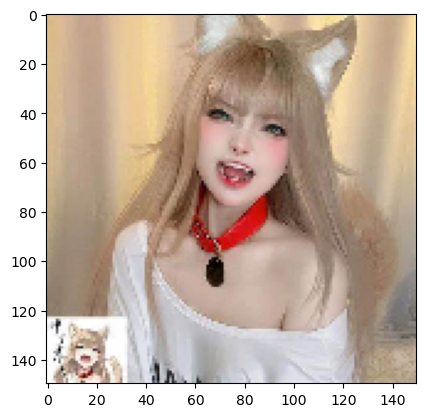

In [4]:
# display the test picture
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Assuming `model_base` is your loaded model
input_shape = (150, 150, 3)  # Example input shape, adjust as necessary

# Create a new input layer
new_input = Input(shape=input_shape)

# Use the loaded model, connecting the new input layer to it
# Note: Ensure the loaded model's first layer can accept the new input shape
new_output = model_base(new_input)

# Create a new model
new_model = Model(inputs=new_input, outputs=new_output)

# instantiating a model from an input tensor and a list of output tensors
model = new_model

from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:9]]  # extracts the outputs of the top 8 layers   
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # creates a model that will return these outputs, given the model input

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │     3,453,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
activations = activation_model.predict(img_tensor)  # returns a list of five Numpy arrays: one array per layer activation
first_layer_activation = activations[0]  # first layer activation
print(first_layer_activation.shape)  # shape: (1, 150, 150, 32)

I0000 00:00:1720772900.493838   12755 service.cc:145] XLA service 0x743cb0004760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720772900.493863   12755 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-07-12 16:28:20.498636: W tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:292] cannot create directory '/path/to/reproducer': /path; Permission denied
2024-07-12 16:28:20.499142: W tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:292] cannot create directory '/path/to/reproducer': /path; Permission denied
2024-07-12 16:28:20.502617: W tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:292] cannot create directory '/path/to/reproducer': /path; Permission denied
2024-07-12 16:28:20.502988: W tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:292] cannot create directory '/path/to/reproducer': /path; Permission denied
2024-07-12 16:28:20.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
(1, 150, 150, 3)


I0000 00:00:1720772900.816069   12755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
